In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '../../','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/tetrad-lib-6.4.0-SNAPSHOT-tetradcmd.jar
/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/data-reader-0.2.3-SNAPSHOT.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(), '../../','data', 'audiology.txt')
data_dir

'/home/jovyan/py-causal/example/javabridge/../../data/audiology.txt'

In [5]:
dframe = pd.read_table(data_dir, sep="\t")
dframe.head()

,age_gt_60,air,airBoneGap,ar_c,ar_u,bone,boneAbnormal,bser,history_buzzing,history_dizziness,...,s_sn_gt_2k,s_sn_gt_4k,speech,static_normal,tymp,viith_nerve_signs,wave_V_delayed,waveform_ItoV_prolonged,indentifier,class
0,f,mild,f,normal,normal,?,t,?,f,f,...,f,f,normal,t,a,f,f,f,p1,cochlear_unknown
1,f,moderate,f,normal,normal,?,t,?,f,f,...,f,f,normal,t,a,f,f,f,p2,cochlear_unknown
2,t,mild,t,?,absent,mild,t,?,f,f,...,f,f,normal,t,as,f,f,f,p3,mixed_cochlear_age_fixation
3,t,mild,t,?,absent,mild,f,?,f,f,...,f,f,normal,t,b,f,f,f,p4,mixed_cochlear_age_otitis_media
4,t,mild,f,normal,normal,mild,t,?,f,f,...,f,f,good,t,a,f,f,f,p5,cochlear_age


In [6]:
dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.VerticalIntDataBox")(len(dframe.index),dframe.columns.size)

In [7]:
node_list = javabridge.JClassWrapper("java.util.ArrayList")()
# load dataset
col_no = 0
for col in dframe.columns:
    
    cat_array = sorted(set(dframe[col]))
    cat_list = javabridge.JClassWrapper("java.util.ArrayList")()

    for cat in cat_array:
        cat = str(cat)
        cat_list.add(cat)
        
    nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.DiscreteVariable")(col, cat_list)
    node_list.add(nodi)
    
    for row in dframe.index:
        value = javabridge.JClassWrapper("java.lang.Integer") (cat_array.index(dframe.iloc[row,col_no]))
        dataBox.set(row,col_no,value)
    
    col_no = col_no + 1

In [8]:
boxData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)

In [9]:
score = javabridge.JClassWrapper("edu.cmu.tetrad.search.BDeuScore")(boxData)
score.setStructurePrior(1.0)
score.setSamplePrior(1.0)

In [10]:
fges = javabridge.JClassWrapper("edu.cmu.tetrad.search.Fges")(score)

In [11]:
fges.setMaxDegree(-1)
fges.setNumPatternsToStore(0)
fges.setFaithfulnessAssumed(True)
fges.setParallelism(2)
fges.setVerbose(True)

In [12]:
prior = javabridge.JClassWrapper('edu.cmu.tetrad.data.Knowledge2')()
prior.setForbidden('history_noise','class') # forbidden directed edges
prior.setForbidden('history_fluctuating','class') # forbidden directed edges
prior.setTierForbiddenWithin(0, True)
prior.addToTier(0, 'class')
prior.addToTier(0, 'history_fluctuating')
prior.addToTier(0, 'history_noise')
fges.setKnowledge(prior)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

0* class history_fluctuating history_noise 

forbiddirect

history_noise ==> class 
history_fluctuating ==> class 
requiredirect


In [13]:
tetradGraph = fges.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: Graph Nodes:
age_gt_60,air,airBoneGap,ar_c,ar_u,bone,boneAbnormal,bser,history_buzzing,history_dizziness,history_fluctuating,history_fullness,history_heredity,history_nausea,history_noise,history_recruitment,history_ringing,history_roaring,history_vomiting,late_wave_poor,m_at_2k,m_cond_lt_1k,m_gt_1k,m_m_gt_2k,m_m_sn,m_m_sn_gt_1k,m_m_sn_gt_2k,m_m_sn_gt_500,m_p_sn_gt_2k,m_s_gt_500,m_s_sn,m_s_sn_gt_1k,m_s_sn_gt_2k,m_s_sn_gt_3k,m_s_sn_gt_4k,m_sn_2_3k,m_sn_gt_1k,m_sn_gt_2k,m_sn_gt_3k,m_sn_gt_4k,m_sn_gt_500,m_sn_gt_6k,m_sn_lt_1k,m_sn_lt_2k,m_sn_lt_3k,middle_wave_poor,mod_gt_4k,mod_mixed,mod_s_mixed,mod_s_sn_gt_500,mod_sn,mod_sn_gt_1k,mod_sn_gt_2k,mod_sn_gt_3k,mod_sn_gt_4k,mod_sn_gt_500,notch_4k,notch_at_4k,o_ar_c,o_ar_u,s_sn_gt_1k,s_sn_gt_2k,s_sn_gt_4k,speech,static_normal,tymp,viith_nerve_signs,wave_V_delayed,waveform_ItoV_prolonged,indentifier,class

Graph Edges:
1. age_gt_60 --- m_m_sn
2. airBoneGap --> air
3. airBoneGap ---

In [14]:
tetradGraph.toString()

'Graph Nodes:\nage_gt_60,air,airBoneGap,ar_c,ar_u,bone,boneAbnormal,bser,history_buzzing,history_dizziness,history_fluctuating,history_fullness,history_heredity,history_nausea,history_noise,history_recruitment,history_ringing,history_roaring,history_vomiting,late_wave_poor,m_at_2k,m_cond_lt_1k,m_gt_1k,m_m_gt_2k,m_m_sn,m_m_sn_gt_1k,m_m_sn_gt_2k,m_m_sn_gt_500,m_p_sn_gt_2k,m_s_gt_500,m_s_sn,m_s_sn_gt_1k,m_s_sn_gt_2k,m_s_sn_gt_3k,m_s_sn_gt_4k,m_sn_2_3k,m_sn_gt_1k,m_sn_gt_2k,m_sn_gt_3k,m_sn_gt_4k,m_sn_gt_500,m_sn_gt_6k,m_sn_lt_1k,m_sn_lt_2k,m_sn_lt_3k,middle_wave_poor,mod_gt_4k,mod_mixed,mod_s_mixed,mod_s_sn_gt_500,mod_sn,mod_sn_gt_1k,mod_sn_gt_2k,mod_sn_gt_3k,mod_sn_gt_4k,mod_sn_gt_500,notch_4k,notch_at_4k,o_ar_c,o_ar_u,s_sn_gt_1k,s_sn_gt_2k,s_sn_gt_4k,speech,static_normal,tymp,viith_nerve_signs,wave_V_delayed,waveform_ItoV_prolonged,indentifier,class\n\nGraph Edges:\n1. age_gt_60 --- m_m_sn\n2. airBoneGap --> air\n3. airBoneGap --- ar_u\n4. airBoneGap --- tymp\n5. ar_c --- o_ar_u\n6. bone

In [15]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [age_gt_60, air, airBoneGap, ar_c, ar_u, bone, boneAbnormal, bser, history_buzzing, history_dizziness, history_fluctuating, history_fullness, history_heredity, history_nausea, history_noise, history_recruitment, history_ringing, history_roaring, history_vomiting, late_wave_poor, m_at_2k, m_cond_lt_1k, m_gt_1k, m_m_gt_2k, m_m_sn, m_m_sn_gt_1k, m_m_sn_gt_2k, m_m_sn_gt_500, m_p_sn_gt_2k, m_s_gt_500, m_s_sn, m_s_sn_gt_1k, m_s_sn_gt_2k, m_s_sn_gt_3k, m_s_sn_gt_4k, m_sn_2_3k, m_sn_gt_1k, m_sn_gt_2k, m_sn_gt_3k, m_sn_gt_4k, m_sn_gt_500, m_sn_gt_6k, m_sn_lt_1k, m_sn_lt_2k, m_sn_lt_3k, middle_wave_poor, mod_gt_4k, mod_mixed, mod_s_mixed, mod_s_sn_gt_500, mod_sn, mod_sn_gt_1k, mod_sn_gt_2k, mod_sn_gt_3k, mod_sn_gt_4k, mod_sn_gt_500, notch_4k, notch_at_4k, o_ar_c, o_ar_u, s_sn_gt_1k, s_sn_gt_2k, s_sn_gt_4k, speech, static_normal, tymp, viith_nerve_signs, wave_V_delayed, waveform_ItoV_prolonged, indentifier, class]

In [16]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [history_buzzing --- wave_V_delayed, middle_wave_poor --- late_wave_poor, bser --- late_wave_poor, airBoneGap --- ar_u, history_fluctuating --> history_recruitment, o_ar_c --- ar_u, history_vomiting --> history_roaring, class --- age_gt_60, class --- tymp, history_roaring --> waveform_ItoV_prolonged, s_sn_gt_2k --- history_heredity, history_recruitment --> m_sn_gt_1k, bone --- boneAbnormal, o_ar_c --- ar_c, notch_4k --- m_m_sn_gt_2k, speech --> air, o_ar_u --- bone, m_sn_lt_1k --> history_fluctuating, class --- notch_at_4k, history_roaring --> history_nausea, ar_c --- o_ar_u, history_noise --- notch_at_4k, airBoneGap --> air, history_dizziness --> history_fluctuating, history_dizziness --- static_normal, age_gt_60 --- m_m_sn, airBoneGap --- tymp, history_dizziness --> history_roaring, history_fullness --- history_buzzing]

In [17]:
graph = pydot.Dot(graph_type='digraph')

In [18]:
n = tetradGraph.getNodeNames().toString()
n = n[1:len(n)-1]
n = n.split(",")
nodes = []
for i in range(0,len(n)):
    node = n[i]
    n[i] = node.strip()
    nodes.append(pydot.Node(n[i]))
    graph.add_node(nodes[i])

In [19]:
def isNodeExisting(nodes,node):
    try:
        nodes.index(node)
        return True
    except IndexError:
        print ("Node {} does not exist!".format (node))
        return False

e = tetradGraph.getEdges().toString()
e = e[1:len(e)-1]
e = e.split(",")
for i in range(0,len(e)):
    e[i] = e[i].strip()
    token = e[i].split(" ")
    if(len(token) >= 3):
        src = token[0]
        arc = token[1]
        dst = token[2]
        if(isNodeExisting(n,src) and isNodeExisting(n,dst)):
            edge = pydot.Edge(nodes[n.index(src)],nodes[n.index(dst)])
            
            if(arc[0] != "-"):
                edge.set_dir("both")
            
            if(arc[0] == "o"):
                edge.set_arrowtail("odot")
            elif(arc[0] == "<"):
                edge.set_arrowtail("normal")
            
            if(arc[2] == "-"):
                edge.set_arrowhead("none")
            elif(arc[2] == "o"):
                edge.set_arrowhead("odot")
            else:
                edge.set_arrowhead("normal")
            
            graph.add_edge(edge)

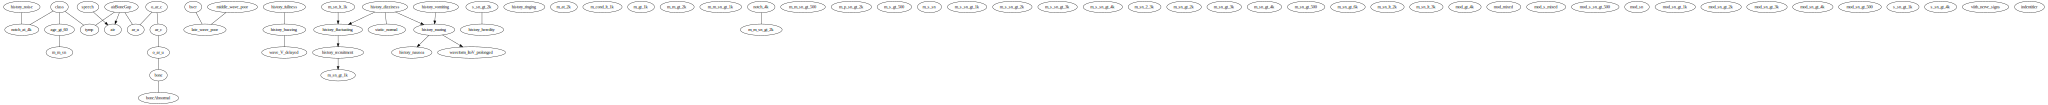

In [20]:
svg_str = graph.create_svg(prog='dot')
SVG(svg_str)

In [21]:
javabridge.detach()
javabridge.kill_vm()